In [1]:
# packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# keras imports
import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# allow memmory dynamic memmory allocation
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# model selection
from sklearn.model_selection import train_test_split

# to get image names
import os, cv2, random
import ntpath

from BatchGenerator import BatchCreator, BatchSequence
from create_model import create_VGG
from data_utils import load_ava, clean_data

# random seed to make the kernel reproducible
random_seed = 123456789
np.random.seed(random_seed)

Using TensorFlow backend.


In [2]:
# directory where we are going to work on
workdir = './data'

In [3]:
# Create result dir
result_dir = './results' # define here the directory where your results will be saved
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

# Dataset description

**************************************************************************
Content of **AVA.txt**
**************************************************************************

* **Column 1:** Index

* **Column 2:** Image ID 

* **Columns 3 - 12:** Counts of aesthetics ratings on a scale of 1-10. Column 3 has counts of ratings of 1 and column 12 has counts of ratings of 10.

* **Columns 13 - 14:** Semantic tag IDs. There are 66 IDs ranging from 1 to 66. The file tags.txt contains the textual tag corresponding to the numerical id. Each image has between 0 and 2 tags. Images with less than 2 tags have a "0" in place of the missing tag(s).

* **Column 15:** Challenge ID. The file challenges.txt contains the name of the challenge corresponding to each ID.

## Load the data

In [4]:
x_train, y_train = load_ava(workdir)

In [5]:
print(x_train.shape)
print(y_train.shape)

(255530,)
(255530, 10)


## Data cleaning

Once all the data is loaded, we will check if all the images are in the directory and all that are not will be removed.

In [6]:
x_train, y_train = clean_data(workdir, x_train, y_train)

Total images lost:  30868
Original dataset shape:  (255530,)
Resulting dataset shape:  (224662,)


## Data overview

In [7]:
# metrics regarding score distribution
mean_scores = np.sum(y_train * np.arange(1, 11), axis = 1) / (np.sum(y_train, axis = 1) + 1)
mean_scores_rep = np.repeat(mean_scores, 10, axis = 0).reshape(len(y_train), 10)
stds_scores = np.sqrt((np.sum(np.abs(np.arange(1, 11) - mean_scores_rep) ** 2 * y_train, axis = 1)) / (np.sum(y_train, axis = 1)))

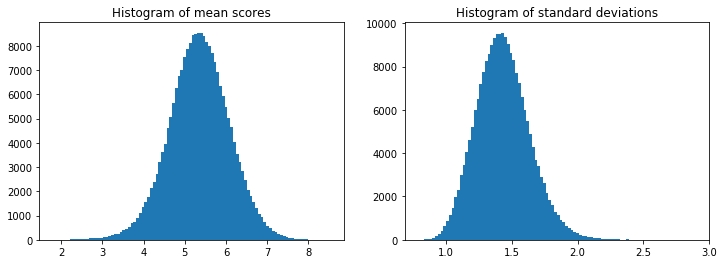

In [8]:
# rating distribution mean over all the dataset
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Histogram of mean scores')
plt.hist(mean_scores, bins = 100)
plt.subplot(1, 2, 2)
plt.title('Histogram of standard deviations')
plt.hist(stds_scores, bins = 100)
plt.show()

Filename:  439330.jpg


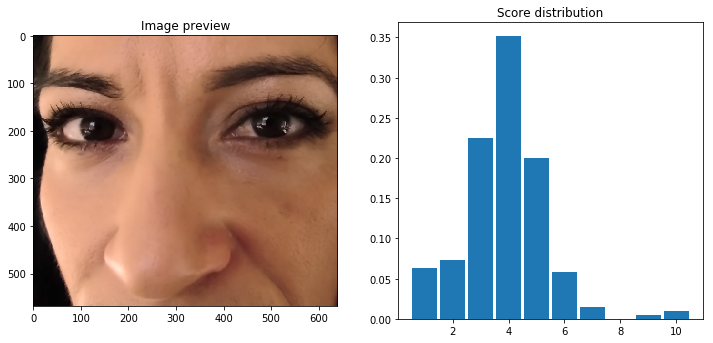

Filename:  825995.jpg


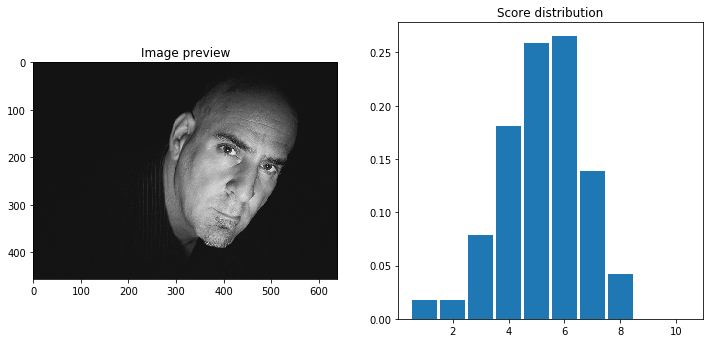

Filename:  861213.jpg


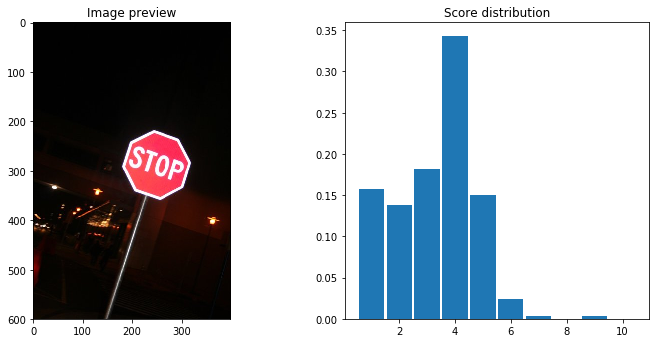

In [9]:
# number of random samples to be plotted
n_rand_samples = 3

# define directory of training images
train_dir_images = os.path.join(workdir, 'images')

# plot n_rand_samples
for i in range(n_rand_samples):

    # pick random training image
    case = os.path.join(train_dir_images, random.choice(os.listdir(train_dir_images)))
    case_filename = os.path.splitext(ntpath.basename(case))[0] + '.jpg'
    print("Filename: ", case_filename)
    
    # open image with opencv and visualize it
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)

    image = cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB) # cv2 loads an image BGR rather than RGB
    plt.title('Image preview')
    plt.imshow(image)
    
    # plot the score distribution of the image
    plt.subplot(2, 2, 2)

    punt = y_train[x_train == int(os.path.splitext(ntpath.basename(case))[0])][0]
    punt = punt / np.sum(punt)
    plt.title('Score distribution')
    plt.bar(np.arange(1,11), height = punt, width = 0.9)
    plt.show()

**********************

Since the **255530** images are impossible to be loaded in memory, we will use a technique that will let us load images during the training process. Using this technique, we won't need to create a dataset beforehand and then use it to train you network, but we will just have a list of training images available, and images will be extracted **on-the-fly** during training. This strategy allows to save time in the preparation the static dataset as well as memmory, and allows the use of a dynamic generation of batches, where data augmentation can also be applied on-the-fly.

Once the BatchCreator is defined, it will be tested

BatchCreator: 224662 patch samples.


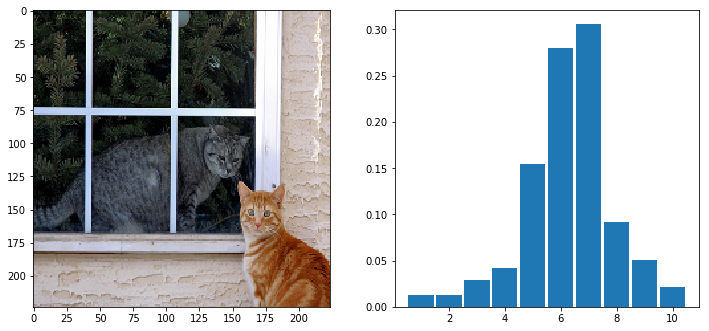

In [10]:
training_gen = BatchCreator(x_train, y_train, 16, train_dir_images)

# create a batch
for batch_x, batch_y in training_gen:
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.imshow(batch_x[0])
    plt.subplot(2, 2, 2)
    plt.bar(np.arange(1,11), height = batch_y[0], width = 0.9)
    plt.show()
    break

PatchSequence: 224662 patch samples.


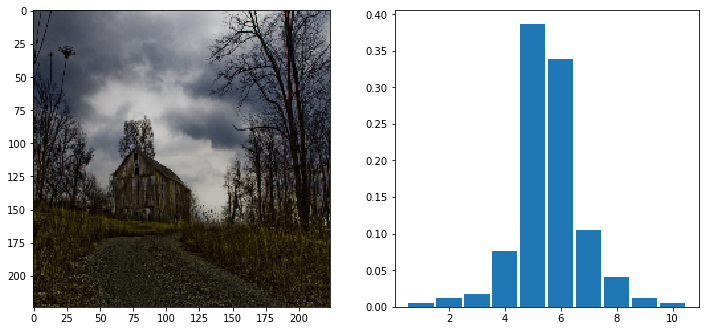

In [11]:
validation_gen = BatchSequence(x_train, y_train, 16, train_dir_images)

# create a batch
for batch_x, batch_y in validation_gen:
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.imshow(batch_x[0])
    plt.subplot(2, 2, 2)
    plt.bar(np.arange(1,11), height = batch_y[0], width = 0.9)
    plt.show()
    break

Once we have created the BatchCreator and the BatchSequence, we will split our dataset in trainig and validation.

In [12]:
# split train and validationy_train
x_train, x_validation, y_train, y_validation = train_test_split(x_train, 
                                                                y_train, 
                                                                test_size = 0.2,
                                                                random_state = random_seed)

After splitting the dataset, we will define the loss function `EMD` (Earth Mover’s Distance). Whose equation is the following one:

$$ EMD(p, \widehat{p}) = \left ( \frac{1}{N} \sum_{k=1}^{N} \left | CDF_{p} \left ( k \right ) - CDF_{\widehat{p}}\left ( k \right ) \right |^{r} \right )^{1/r} $$

Where `CDF` is the cummulative distribution, and `r` is fixed to 2 to penalize the Euclidean distance between the
CDFs and allows easier optimization when working with gradient descent.

In [13]:
def emd_loss(y_true, y_pred):
    '''
    Earth Mover's Distance loss
    '''
    cdf_p    = K.cumsum(y_true, axis = -1)
    cdf_phat = K.cumsum(y_pred, axis = -1)
    loss     = K.mean(K.sqrt(K.mean(K.square(K.abs(cdf_p - cdf_phat)), axis = -1)))
    
    return loss

In [14]:
vgg_16 = create_VGG()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
# learning rate
learning_rate = 1e-2

# metrics
metrics = ['accuracy']

# optimizer and model compile
optimizer = Adam(lr = learning_rate)
vgg_16.compile(optimizer, emd_loss, metrics)

In [16]:
# training
checkpoint = ModelCheckpoint(os.path.join(result_dir, 'best_model.h5'), 
                             monitor = 'val_loss',
                             verbose = 1,
                             save_weights_only = True,
                             save_best_only = True,
                             mode = 'min')

# batch size and number of epochs
batch_size = 50
epochs = 3

# create the Batches and obtain the generatoros
training_data = BatchCreator(x_train, y_train, batch_size, train_dir_images)
validation_data = BatchSequence(x_validation, y_validation, batch_size, train_dir_images)

# fit the model
vgg_16.fit_generator(training_data,
                     steps_per_epoch = 180000//(batch_size * 50),
                     epochs = epochs,
                     verbose = 1, 
                     callbacks = [checkpoint],
                     validation_data = validation_data,
                     validation_steps = 44932//(batch_size * 50))

BatchCreator: 179729 patch samples.
PatchSequence: 44933 patch samples.
Epoch 1/3
72/72 [==============================] - 55s 766ms/step - loss: 0.2035 - acc: 0.5408 - val_loss: 0.3352 - val_acc: 0.6000

Epoch 00001: val_loss improved from inf to 0.33516, saving model to ./results/best_model.h5
Epoch 2/3
72/72 [==============================] - 49s 686ms/step - loss: 0.2051 - acc: 0.5708 - val_loss: 0.3352 - val_acc: 0.6000

Epoch 00002: val_loss did not improve from 0.33516
Epoch 3/3
72/72 [==============================] - 49s 684ms/step - loss: 0.2034 - acc: 0.5794 - val_loss: 0.3352 - val_acc: 0.6000

Epoch 00003: val_loss did not improve from 0.33516
